In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [2]:
# sys.argv = ['tensorize',
#             '--mode', 'tensorize_ludb',
#             '--xml_folder', f'{HOME_PATH}/ludb/',
#             '--output_folder', f'{HOME_PATH}/ludb_tensors/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--min_sample_id', '1', 
#             '--max_sample_id', '201'
#            ]
# args = parse_args()
# run(args)

['electric axis of the heart: left axis deviation left ventricular hypertrophy left ventricular overload non-specific repolarization abnormalities: posterior wall']


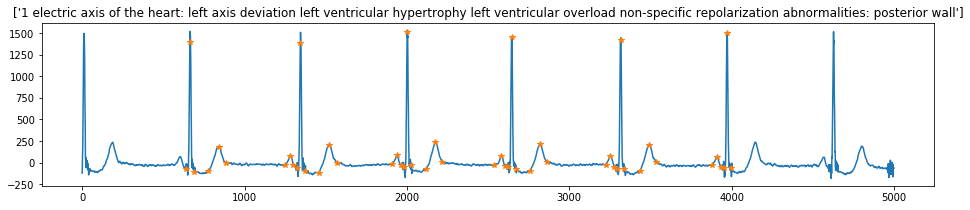

In [3]:
%matplotlib inline
for i in range(1, 200):
    with h5py.File(f'{HOME_PATH}/ludb_tensors/{i}.hd5', 'r') as hd5:
        f, ax = plt.subplots()
        f.set_size_inches(16, 3)
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        ax.plot(data)
        ax.plot(ann, data[ann], '*')
        print(hd5['ecg_rest_text'][()])
        ax.set_title(str(i) + ' ' + hd5['ecg_rest_text'][()])
    break

In [4]:
def annotation_to_segmentation(data, ann, shape = (5000,)):
    cycle = ['QR', 'RS', 'ST1', 'T1T2', 'T2T3', 'T3P1', 'P1P2', 'P2P3', 'P3Q']
    parsed_data = np.zeros(shape)
    parsed_range = ann[-1] - ann[0]
    parsed_data[:parsed_range] = data[ann[0]:ann[-1]]
    segmented_data = np.zeros(shape, dtype=np.int)
    ic = 0
    for ia in range(len(ann)-1):
        segmented_data[ann[ia]-ann[0]:ann[ia+1]-ann[0]] = ic
        ic += 1
        if ic == len(cycle):
            ic = 0
    return parsed_data, segmented_data      

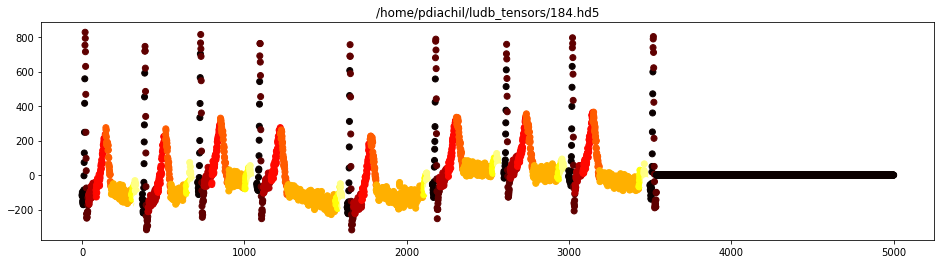

In [5]:
import glob
from matplotlib import cm
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:        
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        parsed, segmented = annotation_to_segmentation(data, ann)
        f, ax = plt.subplots()
        f.set_size_inches(16, 4)
        ax.scatter(range(len(parsed)), parsed, c=cm.hot(segmented/8.0))
        ax.set_title(hd5_path)
        
    break

In [6]:
import glob
from ml4cvd.arguments import _get_tmap
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
tm_data = _get_tmap('ecg_rest_ludb')
tm_segmentation = _get_tmap('ecg_rest_ludb_segmentation_weighted')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:
        data = tm_data.tensor_from_file(tm_data, hd5)
        segmentation = tm_segmentation.tensor_from_file(tm_segmentation, hd5)
    break

In [7]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation',
#             '--id', 'test_ludb_segmentation',
#             '--num_workers', '0',
#             '--inspect_model',
#             '--training_steps', '14',
#             '--validation_steps', '2',
#             '--test_steps', '2',
#             '--batch_size', '4',
#             '--epochs', '100'
#            ]
# args = parse_args()
# run(args)

In [8]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap], dependent_tmap):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    dependents = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5, dependents)
                        for dependent in dependents:
                            result_dict[dependent] = np.array(dependents[dependent])
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys(), dependent_tmap), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size, dependent_tmap
    )

def tmap_dic_to_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_subcols = []
    out_dic = {'sample_id': []}
        
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)] = np.zeros(len(tmap_dic))
        break
    
    for i, entry in enumerate(tmap_dic):
        out_dic['sample_id'].append(entry)
        for t in tmap_dic[entry]:   
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)][i] = tmap_dic[entry][t].ravel()[n]
    return out_dic

In [ ]:
a = tmaps_by_sample_id('/home/pdiachil/ludb_tensors/', '1', [_get_tmap('ecg_rest_ludb')], _get_tmap('ecg_rest_ludb_segmentation_coarse'))

b = tmaps_with_properties_from_keys(
    '/home/pdiachil/ludb_tensors/', 
    {
        'ecg_rest_ludb': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_rest_ludb_segmentation_coarse')
)

In [ ]:
dd = tmap_dic_to_dic(b)

In [ ]:
df = pd.DataFrame(dd)
df

,sample_id,ecg_rest_ludb_0,ecg_rest_ludb_1,ecg_rest_ludb_2,ecg_rest_ludb_3,ecg_rest_ludb_4,ecg_rest_ludb_5,ecg_rest_ludb_6,ecg_rest_ludb_7,ecg_rest_ludb_8,...,ecg_rest_ludb_segmentation_279990,ecg_rest_ludb_segmentation_279991,ecg_rest_ludb_segmentation_279992,ecg_rest_ludb_segmentation_279993,ecg_rest_ludb_segmentation_279994,ecg_rest_ludb_segmentation_279995,ecg_rest_ludb_segmentation_279996,ecg_rest_ludb_segmentation_279997,ecg_rest_ludb_segmentation_279998,ecg_rest_ludb_segmentation_279999
0,1,-0.027557,-0.033217,-0.008750,-0.159209,-0.159211,-0.108428,-0.080229,-0.036991,-0.033535,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10,0.008581,0.008581,0.008581,0.008581,0.008581,0.008581,0.008581,0.008581,0.008581,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,0.126185,0.126185,0.126185,0.126185,0.126185,0.126185,0.126185,0.126185,0.126185,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,102,0.566545,0.359073,-0.872123,0.595217,0.351898,0.545149,0.702523,1.955314,0.487912,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,106,0.070481,0.069549,0.074009,0.072894,0.070684,0.074415,0.072488,0.071069,0.068944,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,107,0.099433,0.099433,0.099433,0.099433,0.099433,0.099433,0.099433,0.099433,0.099433,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,108,-0.697677,-0.680655,-0.527979,-2.394484,-0.782361,-1.206743,-1.715716,0.142200,-0.698086,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,11,-0.641343,0.549677,-0.259780,-1.004120,-1.125028,-2.148645,-0.985423,-0.427250,-0.642118,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,113,-0.092876,-0.119328,-0.159123,-0.476895,-0.741686,-1.072673,-0.940473,-0.609286,-0.053353,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,119,-0.291666,-0.574908,-0.291741,-0.574936,-0.575019,-0.999917,-0.858415,-0.433385,-0.292002,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# cols = [f'ecg_rest_ludb_segmentation_{i}' for i in range(0, 40000, 2)]
# df[cols].apply(pd.Series.value_counts)

In [ ]:
# 2900000.0 / df[cols].apply(pd.Series.value_counts).sum(axis=1)/20.390944

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ludb_output/',
            '--tensors', f'{HOME_PATH}/ludb_tensors/',
            '--input_tensors', 'ecg_rest_ludb',
            '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
            '--id', 'test_ludb_coarse_segmentation_roll_wave',
            '--num_workers', '0',
            '--inspect_model',
            '--training_steps', '15',
            '--validation_steps', '5',
            '--test_steps', '5',
            '--batch_size', '8',
            '--epochs', '400',
            '--patience', '40'            
           ]
args = parse_args()
run(args)

2020-01-28 17:53:06,737 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_wave/log_2020-01-28_17-53_0.log.
2020-01-28 17:53:06,738 - arguments:207 - INFO - Command Line was:

./scripts/tf.sh train --mode train --output_folder /home/pdiachil/ludb_output/ --tensors /home/pdiachil/ludb_tensors/ --input_tensors ecg_rest_ludb --output_tensors ecg_rest_ludb_segmentation_coarse --id test_ludb_coarse_segmentation_roll_wave --num_workers 0 --inspect_model --training_steps 15 --validation_steps 5 --test_steps 5 --batch_size 8 --epochs 400 --patience 40



2020-01-28 17:53:06,739 - arguments:208 - INFO - Total TensorMaps:394 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=8, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r1

2020-01-28 17:53:07,763 - models:827 - INFO - Saving architecture diagram to:/home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_wave/architecture_graph_test_ludb_coarse_segmentation_roll_wave.png
Epoch 1/1
2020-01-28 17:53:10,777 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-01-28 17:53:10,780 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-01-28 17:53:10,782 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.129 GB.
2020-01-28 17:53:10,785 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.044 GB.
2020-01-28 17:53:12,086 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	35 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.30 seconds elapsed.
2020

 9/15 [=================>............] - ETA: 1s - loss: 0.6637 - categorical_accuracy: 0.1079 - background_precision: 0.0000e+00 - qrs_precision: 0.0000e+00 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.0000e+00 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 17:53:25,598 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 9:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.25 seconds elapsed.
11/15 [=====================>........] - ETA: 1s - loss: 0.6647 - categorical_accuracy: 0.1087 - background_precision: 0.0000e+00 - qrs_precision:

 2/15 [===>..........................] - ETA: 1s - loss: 0.6431 - categorical_accuracy: 0.1154 - background_precision: 0.0000e+00 - qrs_precision: 0.9517 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.2492 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-28 17:53:33,645 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 12:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.01 seconds elapsed.
 4/15 [=======>......................] - ETA: 2s - loss: 0.6426 - categorical_accuracy: 0.1169 - background_precision: 0.0000e+00 - qrs_precision: 0.9380

15/15 [==============================] - 3s 204ms/step - loss: 0.6151 - categorical_accuracy: 0.1280 - background_precision: 0.0000e+00 - qrs_precision: 0.8441 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.4500 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+00 - val_loss: 0.6111 - val_categorical_accuracy: 0.1173 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.8495 - val_st_precision: 0.0000e+00 - val_t_precision: 0.0000e+00 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.0000e+00 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.4656 - val_st_recall: 0.0000e+00 - val_t_recall: 0.0000e+00 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.0000e+00

Epoch 00006: val_loss improved from 0.62663 to 0.61107, saving

15/15 [==============================] - 3s 204ms/step - loss: 0.5981 - categorical_accuracy: 0.1983 - background_precision: 0.0000e+00 - qrs_precision: 0.8512 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.1139 - background_recall: 0.0000e+00 - qrs_recall: 0.5414 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 1.7025e-05 - val_loss: 0.5579 - val_categorical_accuracy: 0.2895 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.8426 - val_st_precision: 0.0000e+00 - val_t_precision: 0.0000e+00 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.0808 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.4999 - val_st_recall: 0.0000e+00 - val_t_recall: 0.0000e+00 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 2.2754e-04

Epoch 00009: val_loss improved from 0.61107 to 0.55789, saving model t

10/15 [===================>..........] - ETA: 1s - loss: 0.5674 - categorical_accuracy: 0.4572 - background_precision: 0.0000e+00 - qrs_precision: 0.8984 - st_precision: 0.2465 - t_precision: 0.8802 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.4003 - background_recall: 0.0000e+00 - qrs_recall: 0.6080 - st_recall: 2.0102e-04 - t_recall: 0.0177 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.01682020-01-28 17:54:00,342 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 16:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.75 seconds elapsed.
15/15 [==============================] - 3s 205ms/step - loss: 0.5633 - categorical_accuracy: 0.4603 - background_precision: 0.0000e+00 - qrs_precision: 0.9014 - st_precision:

 3/15 [=====>........................] - ETA: 1s - loss: 0.5293 - categorical_accuracy: 0.5331 - background_precision: 0.0000e+00 - qrs_precision: 0.8122 - st_precision: 0.6919 - t_precision: 0.7530 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.6661 - background_recall: 0.0000e+00 - qrs_recall: 0.6730 - st_recall: 0.0311 - t_recall: 0.0987 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.15272020-01-28 17:54:08,413 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 19:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.52 seconds elapsed.
15/15 [==============================] - 3s 200ms/step - loss: 0.5260 - categorical_accuracy: 0.5232 - background_precision: 0.0000e+00 - qrs_precision: 0.8744 - st_precision: 0.6


Epoch 00017: val_loss did not improve from 0.49356
Epoch 18/400
 4/15 [=======>......................] - ETA: 2s - loss: 0.4921 - categorical_accuracy: 0.5856 - background_precision: 0.0000e+00 - qrs_precision: 0.8900 - st_precision: 0.6598 - t_precision: 0.8431 - tp_precision: 0.0944 - p_precision: 0.0000e+00 - pq_precision: 0.7177 - background_recall: 0.0000e+00 - qrs_recall: 0.7398 - st_recall: 0.1063 - t_recall: 0.1795 - tp_recall: 4.9810e-05 - p_recall: 0.0000e+00 - pq_recall: 0.2493   2020-01-28 17:54:18,122 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 29:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.83 seconds elapsed.
 8/15 [===============>..............] - ETA: 1s - loss: 0.5023 - categorical_accuracy: 0.5810 - background_preci

 1/15 [=>............................] - ETA: 1s - loss: 0.4498 - categorical_accuracy: 0.6454 - background_precision: 0.0000e+00 - qrs_precision: 0.8798 - st_precision: 0.6958 - t_precision: 0.9194 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.6868 - background_recall: 0.0000e+00 - qrs_recall: 0.7585 - st_recall: 0.1580 - t_recall: 0.1549 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.32542020-01-28 17:54:26,801 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 26:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.46 seconds elapsed.
 2/15 [===>..........................] - ETA: 1s - loss: 0.4442 - categorical_accuracy: 0.6539 - background_precision: 0.0000e+00 - qrs_precision: 0.8788 - st_precision: 0.7093 - 

15/15 [==============================] - 3s 197ms/step - loss: 0.4326 - categorical_accuracy: 0.6608 - background_precision: 0.8865 - qrs_precision: 0.8867 - st_precision: 0.6764 - t_precision: 0.8953 - tp_precision: 0.3314 - p_precision: 0.0062 - pq_precision: 0.7409 - background_recall: 0.6532 - qrs_recall: 0.7475 - st_recall: 0.1875 - t_recall: 0.2391 - tp_recall: 0.0014 - p_recall: 1.0263e-04 - pq_recall: 0.3443 - val_loss: 0.4776 - val_categorical_accuracy: 0.6176 - val_background_precision: 0.9005 - val_qrs_precision: 0.7931 - val_st_precision: 0.6361 - val_t_precision: 0.6968 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.6422 - val_background_recall: 0.7741 - val_qrs_recall: 0.5883 - val_st_recall: 0.1726 - val_t_recall: 0.2722 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.3118

Epoch 00023: val_loss did not improve from 0.42829
Epoch 24/400
 4/15 [=======>......................] - ETA: 2s - loss: 0.4171 - categori


Epoch 00026: val_loss did not improve from 0.42520
Epoch 27/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.3685 - categorical_accuracy: 0.6814 - background_precision: 0.9186 - qrs_precision: 0.8604 - st_precision: 0.7208 - t_precision: 0.9564 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.7889 - background_recall: 0.8313 - qrs_recall: 0.8663 - st_recall: 0.2702 - t_recall: 0.2301 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.43222020-01-28 17:54:45,665 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 39:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.94 seconds elapsed.
12/15 [=======================>......] - ETA: 0s - loss: 0.4061 - categorical_accuracy: 0.6694 - background_precision: 0

 4/15 [=======>......................] - ETA: 2s - loss: 0.4061 - categorical_accuracy: 0.6691 - background_precision: 0.9404 - qrs_precision: 0.8456 - st_precision: 0.6428 - t_precision: 0.8779 - tp_precision: 0.2438 - p_precision: 0.0000e+00 - pq_precision: 0.7892 - background_recall: 0.8815 - qrs_recall: 0.7759 - st_recall: 0.2296 - t_recall: 0.2958 - tp_recall: 0.0023 - p_recall: 0.0000e+00 - pq_recall: 0.40532020-01-28 17:54:55,671 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 43:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.06 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.3949 - categorical_accuracy: 0.6752 - background_precision: 0.9446 - qrs_precision: 0.8518 - st_precision: 0.6546 - t_precision: 0.886

 1/15 [=>............................] - ETA: 1s - loss: 0.3499 - categorical_accuracy: 0.7127 - background_precision: 0.9268 - qrs_precision: 0.9020 - st_precision: 0.6750 - t_precision: 0.9105 - tp_precision: 0.9476 - p_precision: 0.0000e+00 - pq_precision: 0.7928 - background_recall: 0.9597 - qrs_recall: 0.7975 - st_recall: 0.2399 - t_recall: 0.3686 - tp_recall: 0.0043 - p_recall: 0.0000e+00 - pq_recall: 0.48982020-01-28 17:55:04,466 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 46:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.01 seconds elapsed.
11/15 [=====================>........] - ETA: 0s - loss: 0.3747 - categorical_accuracy: 0.7169 - background_precision: 0.9476 - qrs_precision: 0.8962 - st_precision: 0.6614 - t_precision: 0.888


Epoch 00035: val_loss improved from 0.35839 to 0.33206, saving model to /home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_wave/test_ludb_coarse_segmentation_roll_wave.hd5
Epoch 36/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.3713 - categorical_accuracy: 0.7195 - background_precision: 0.9772 - qrs_precision: 0.8941 - st_precision: 0.6240 - t_precision: 0.8566 - tp_precision: 0.8463 - p_precision: 0.1011 - pq_precision: 0.7880 - background_recall: 0.9777 - qrs_recall: 0.7489 - st_recall: 0.2709 - t_recall: 0.3363 - tp_recall: 0.0550 - p_recall: 1.0737e-04 - pq_recall: 0.4562   2020-01-28 17:55:14,394 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 50:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.99 seconds elapse


Epoch 00038: val_loss did not improve from 0.33206
Epoch 39/400
 1/15 [=>............................] - ETA: 1s - loss: 0.4854 - categorical_accuracy: 0.6814 - background_precision: 0.9627 - qrs_precision: 0.8617 - st_precision: 0.6068 - t_precision: 0.7108 - tp_precision: 0.9637 - p_precision: 0.0303 - pq_precision: 0.7651 - background_recall: 0.9765 - qrs_recall: 0.6768 - st_recall: 0.2488 - t_recall: 0.3801 - tp_recall: 0.0080 - p_recall: 2.4253e-04 - pq_recall: 0.34982020-01-28 17:55:23,004 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 53:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.85 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.3749 - categorical_accuracy: 0.7086 - background_precision: 0.9716 - qrs_

 2/15 [===>..........................] - ETA: 1s - loss: 0.3346 - categorical_accuracy: 0.7259 - background_precision: 0.9772 - qrs_precision: 0.8882 - st_precision: 0.7322 - t_precision: 0.8915 - tp_precision: 0.9185 - p_precision: 0.0000e+00 - pq_precision: 0.7516 - background_recall: 0.9181 - qrs_recall: 0.8221 - st_recall: 0.2839 - t_recall: 0.2926 - tp_recall: 0.0164 - p_recall: 0.0000e+00 - pq_recall: 0.46112020-01-28 17:55:32,562 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 51:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.40 seconds elapsed.
 3/15 [=====>........................] - ETA: 2s - loss: 0.3627 - categorical_accuracy: 0.7175 - background_precision: 0.9775 - qrs_precision: 0.8626 - st_precision: 0.7158 - t_precision: 0.8707 


Epoch 00044: val_loss did not improve from 0.33206
Epoch 45/400
2020-01-28 17:55:41,488 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 60:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	33 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.82 seconds elapsed.
 7/15 [=============>................] - ETA: 1s - loss: 0.3646 - categorical_accuracy: 0.7169 - background_precision: 0.9831 - qrs_precision: 0.8793 - st_precision: 0.6647 - t_precision: 0.8900 - tp_precision: 0.9068 - p_precision: 0.1678 - pq_precision: 0.7461 - background_recall: 0.9867 - qrs_recall: 0.7371 - st_recall: 0.2755 - t_recall: 0.3281 - tp_recall: 0.0433 - p_recall: 0.0033 - pq_recall: 0.47212020-01-28 17:55:43,103 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 55:
	The following errors occurred:
		
	G

In [ ]:
i = np.arange(5000)
warped = (np.random.rand() * 100 * np.sin(i / (500 + np.random.rand() * 100))
                          + np.random.rand() * 100 * np.cos(i / (500 + np.random.rand() * 100)))
plt.plot(warped)